In [82]:
import torch
from torch import nn, optim
import torch.nn.functional as F

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

image = mpimg.imread('cameraman.tif')

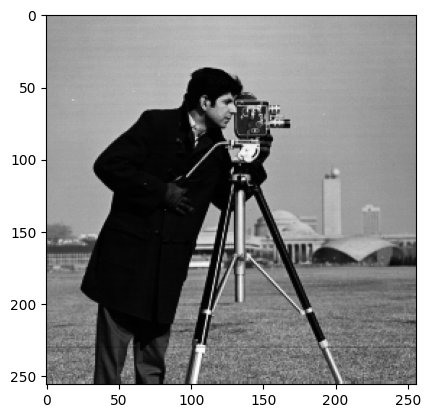

In [83]:
plt.imshow(image, cmap='gray')

In [111]:
image.shape

(256, 256)

In [84]:
image_tensor = torch.tensor(image, dtype=torch.float32) / 255.0

In [85]:
F.grid_sample(image_tensor.unsqueeze(0).unsqueeze(0), torch.tensor([[[[1., 1.]]]], dtype=torch.float32), align_corners=True, mode='nearest')

tensor([[[[0.4431]]]])

In [104]:
class MLP(nn.Module):
    def __init__(self, dim, hidden_dim = 1024):
        super(MLP, self).__init__()
        self.fc_in = nn.Linear(dim, hidden_dim)
        self.layers = nn.Sequential(
            *[
                nn.Linear(hidden_dim, hidden_dim),
            ] * 8
        )
        self.fc_out = nn.Sequential(nn.Linear(hidden_dim, 1))
        

    def forward(self, x):
        x = self.fc_in(x)
        x = F.gelu(x)
        for layer in self.layers:
            x = layer(x)
            x = x + F.gelu(x)
        x = self.fc_out(x)
        return x
    
mlp = MLP(1024).cuda()
image_tensor = image_tensor.cuda()

adam = optim.Adam(mlp.parameters(), lr=1e-4)


In [105]:
batch_size = 1
num_samples_per_batch = 1024

def reflective_sin_emb(x, dim):
    result = []
    for i in range(1, dim + 1, 2):
        result.append(torch.sin(i / 2 * torch.pi * x))
    return torch.stack(result, dim=-1)

i = 0 
while True:

    # random coordinates in [-1, 1]
    random_coordinates = torch.rand(batch_size, num_samples_per_batch, 2, device='cuda') * 2 - 1
    # F.grid_sample(image_tensor.unsqueeze(0).unsqueeze(0), torch.tensor([[[[1., 1.]]]], dtype=torch.float32), align_corners=True, mode='nearest')
    targets = F.grid_sample(image_tensor.unsqueeze(0).unsqueeze(0), random_coordinates.unsqueeze(2), align_corners=True, mode='nearest')
    targets = targets.squeeze(1).squeeze(-1)

    random_coordinates = random_coordinates.squeeze(0)

    embedded_coordinates = torch.cat([reflective_sin_emb(random_coordinates[:, 0], 1024), reflective_sin_emb(random_coordinates[:, 1], 1024)], dim=-1)

    output = mlp(embedded_coordinates)
    
    loss = F.mse_loss(output[:, 0], targets[0])

    adam.zero_grad()
    loss.backward()
    adam.step()

    i += 1

    if i % 1 == 0:
        print(f'iteration {i}, loss: {loss.item()}')




iteration 1, loss: 0.2550225853919983
iteration 2, loss: 0.09700912237167358
iteration 3, loss: 0.06845198571681976
iteration 4, loss: 0.11017363518476486
iteration 5, loss: 0.09397271275520325
iteration 6, loss: 0.06277044117450714
iteration 7, loss: 0.05902509391307831
iteration 8, loss: 0.06891441345214844
iteration 9, loss: 0.07611513137817383
iteration 10, loss: 0.07731074094772339
iteration 11, loss: 0.07263994961977005
iteration 12, loss: 0.06680569052696228
iteration 13, loss: 0.06288133561611176
iteration 14, loss: 0.05986185371875763
iteration 15, loss: 0.058744706213474274
iteration 16, loss: 0.0650705099105835
iteration 17, loss: 0.06347059458494186
iteration 18, loss: 0.0632769986987114
iteration 19, loss: 0.05838264152407646
iteration 20, loss: 0.05439828336238861
iteration 21, loss: 0.056892380118370056
iteration 22, loss: 0.05560576543211937
iteration 23, loss: 0.05710481107234955
iteration 24, loss: 0.061673007905483246
iteration 25, loss: 0.05550363287329674
iteration

KeyboardInterrupt: 

In [127]:
# meshgrid between -1 and 1
size = 128
repeats = 16
x = torch.linspace(-1, -1 + repeats * 2, size * repeats)
y = torch.linspace(-1, -1 + repeats * 2, size * repeats)
x, y = torch.meshgrid(x, y, indexing='xy')

mlp = mlp.cpu()

# evaluate the model on the meshgrid
with torch.no_grad():
    embedded_coordinates = torch.cat([reflective_sin_emb(x.reshape(-1), 1024), reflective_sin_emb(y.reshape(-1), 1024)], dim=-1).cpu()
    output = mlp(embedded_coordinates)
    output = output.view(size * repeats, size * repeats)

plt.imshow(output.cpu(), cmap='gray')
plt.savefig("test.png")

: 